In [17]:
import os, time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigs

import pcms.tree
import pcms.haar

In [18]:
DATA = os.environ['DATA']
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')

## Planted Critical Beta-splitting Tree

In [19]:
t1 = pcms.tree.cbst(5, planted=True, randomize_edge_lengths=True)

In [20]:
print(t1)

└── X
    └── X
        ├── X
        │   ├── X
        │   │   ├── X
        │   │   │   ├── X
        │   │   │   └── X
        │   │   └── X
        │   └── X
        └── X



In [21]:
n = t1.find_n_leaves()
epl = t1.find_epl()

frac = 2 * (epl + 1) / (n * n) - 3 / n
nnz_max = int(np.ceil(frac * n**2))
n_squared = n**2
density = nnz_max / n_squared

print(f"Number of leaves (n): {n}")
print(f"External path length (EPL): {epl}")
print(f"Sparsity bound: {frac:.4f}")
print(f"Max non-zeros (nnz_max): {nnz_max}")
print(f"Dense matrix size: {n_squared}")
print(f"Sparse density: {density:.4%}")

Number of leaves (n): 5
External path length (EPL): 19
Sparsity bound: 1.0000
Max non-zeros (nnz_max): 25
Dense matrix size: 25
Sparse density: 100.0000%


In [22]:
start = time.time()
Q1, S1 = pcms.haar.sparsify(t1)
print("Elapsed time: ", time.time() - start)

Elapsed time:  0.0004088878631591797


In [23]:
Q1.data

array([ 0.70710678, -0.70710678,  0.40824829,  0.40824829, -0.81649658,
        0.28867513,  0.28867513,  0.28867513, -0.8660254 ,  0.2236068 ,
        0.2236068 ,  0.2236068 ,  0.2236068 , -0.89442719,  0.4472136 ,
        0.4472136 ,  0.4472136 ,  0.4472136 ,  0.4472136 ])

In [24]:
print(Q1[:,0])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2 stored elements and shape (5, 1)>
  Coords	Values
  (0, 0)	0.7071067811865476
  (1, 0)	-0.7071067811865476


In [25]:
print(Q1[:,-1])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 5 stored elements and shape (5, 1)>
  Coords	Values
  (0, 0)	0.4472135954999579
  (1, 0)	0.4472135954999579
  (2, 0)	0.4472135954999579
  (3, 0)	0.4472135954999579
  (4, 0)	0.4472135954999579


In [26]:
print(Q1[:,-2])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 5 stored elements and shape (5, 1)>
  Coords	Values
  (0, 0)	0.22360679774997896
  (1, 0)	0.22360679774997896
  (2, 0)	0.22360679774997896
  (3, 0)	0.22360679774997896
  (4, 0)	-0.8944271909999159


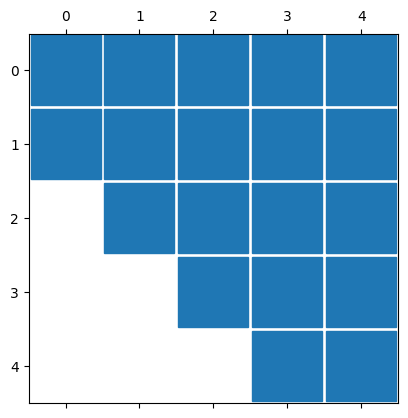

In [27]:
plt.spy(Q1, markersize=50)
plt.show()

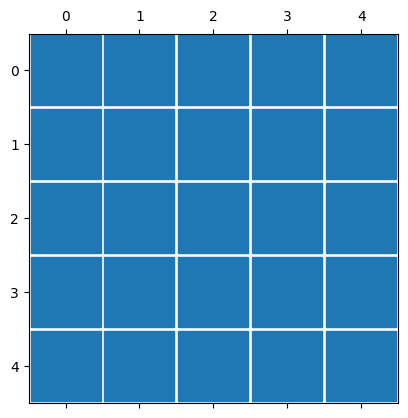

In [28]:
plt.spy(S1, markersize=50)
plt.show()

## Greengenes Tree

In [29]:
t2 = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus_unannotated.nwk'), ensure_planted=True)

In [30]:
n = t2.find_n_leaves()
epl = t2.find_epl()

frac = 2 * (epl + 1) / (n * n) - 3 / n
nnz_max = int(np.ceil(frac * n**2))
n_squared = n**2
density = nnz_max / n_squared

print(f"Number of leaves (n): {n}")
print(f"External path length (EPL): {epl}")
print(f"Sparsity bound: {frac:.4%}")
print(f"Max non-zeros (nnz_max): {nnz_max}")
print(f"Dense matrix size: {n_squared}")

Number of leaves (n): 99322
External path length (EPL): 5118645
Sparsity bound: 0.1008%
Max non-zeros (nnz_max): 9939326
Dense matrix size: 9864859684


In [31]:
start = time.time()
Q2, S2 = pcms.haar.sparsify(t2)
print("Elapsed time: ", time.time() - start)

Elapsed time:  0.34299468994140625


In [16]:
start = time.time()
QQ = Q2.T @ Q2
print("Elapsed time: ", time.time() - start)

Elapsed time:  0.628425121307373


In [17]:
print(Q2.shape, Q2.nnz)

(99322, 99322) 5118645


In [18]:
print(S2.shape, S2.nnz)

(99322, 99322) 9939326


In [ ]:
def percent_sparsity(matrix):
    return 100 * (1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1]))

print(f"Q sparsity: {percent_sparsity(Q2):.4f}%")
print(f"S sparsity: {percent_sparsity(S2):.4f}%")

Q sparsity: 99.9481%
S sparsity: 99.8992%


In [ ]:
def check_csc_rowidx_sorted(matrix: csc_matrix) -> bool:
    """
    Check if the row indices in each column of a CSC sparse matrix are sorted ascending.

    Parameters:
        matrix (csc_matrix): The input CSC sparse matrix.

    Returns:
        bool: True if all columns have sorted row indices, False otherwise.
    """
    indptr = matrix.indptr
    indices = matrix.indices

    for col in range(matrix.shape[1]):
        start = indptr[col]
        end = indptr[col + 1]
        col_indices = indices[start:end]
        if not np.all(col_indices[:-1] <= col_indices[1:]):
            return False
    return True

In [ ]:
print(f"Q row indices sorted: {check_csc_rowidx_sorted(Q2)}")
print(f"S row indices sorted: {check_csc_rowidx_sorted(S2)}")

Q row indices sorted: True
S row indices sorted: True


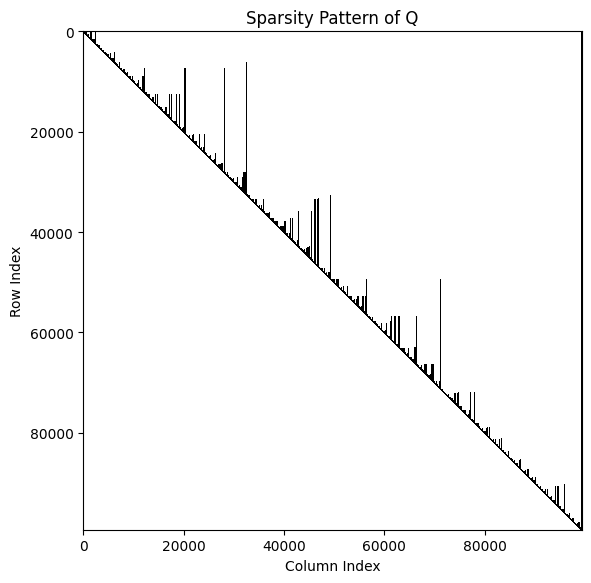

In [ ]:
Q2_coo = Q2.tocoo()

fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=Q2_coo.col, y=Q2_coo.row, s=1, edgecolor=None,
                color="black", marker='.', alpha=0.8, ax=ax)

ax.set_aspect('equal', 'box')
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_title("Sparsity Pattern of Q")
ax.set_xlim(0, Q2.shape[1])
ax.set_ylim(Q2.shape[0], 0)  # invert y-axis for matrix-style plot

plt.tight_layout()
plt.show()


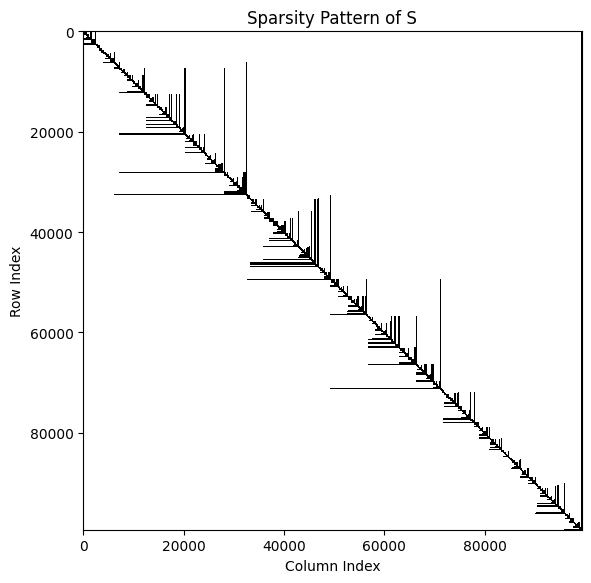

In [ ]:
S2_coo = S2.tocoo()

fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=S2_coo.col, y=S2_coo.row, s=1, edgecolor=None,
                color="black", marker='.', alpha=0.8, ax=ax)

ax.set_aspect('equal', 'box')
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_title("Sparsity Pattern of S")
ax.set_xlim(0, S2.shape[1])
ax.set_ylim(S2.shape[0], 0)  # invert y-axis for matrix-style plot

plt.tight_layout()
plt.show()

In [25]:
n_eigs = 500

In [26]:
ys = S2.diagonal()
sort = np.argsort(ys)[::-1]
ys = ys[sort][0:n_eigs]
xs = np.arange(ys.size)
ys = np.log10(ys)

In [27]:
lams_ = eigs(S2, k=n_eigs, which='LM')

In [28]:
lams = np.sort(np.abs(lams_[0]))[::-1]
lams = np.log10(lams)

/tmp/ipykernel_13827/1287762746.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


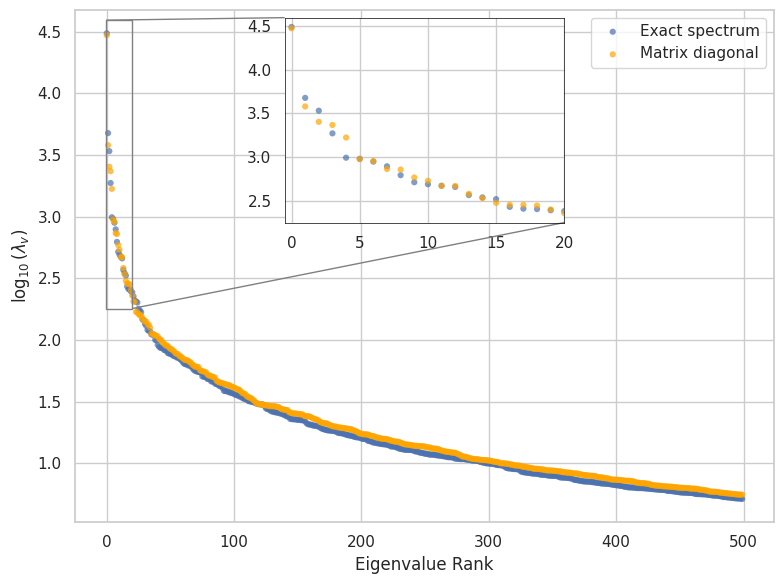

In [29]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter points on main axes
sns.scatterplot(
    x=xs,
    y=lams,
    s=20,
    color='b',
    alpha=0.7,
    edgecolor='none',
    label='Exact spectrum',
    ax=ax
)
sns.scatterplot(
    x=xs,
    y=ys,
    s=20,
    color='orange',
    alpha=0.7,
    edgecolor='none',
    label='Matrix diagonal',
    ax=ax
)

# Create zoom inset axes
axins = inset_axes(ax, width="40%", height="40%", loc='upper center')

# Adjust thickness
for spine in axins.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

# Scatter points on inset axes
sns.scatterplot(
    x=xs, 
    y=lams, 
    s=20, 
    color='b', 
    alpha=0.7, 
    edgecolor='none', 
    ax=axins
)
sns.scatterplot(
    x=xs, 
    y=ys, 
    s=20, 
    color='orange', 
    alpha=0.7, 
    edgecolor='none', 
    ax=axins
)

# Define zoom x-range
x_min, x_max = -0.5, 20
axins.set_xlim(x_min, x_max)

# Select y values corresponding to x in [0,20] for both datasets
mask = (xs >= x_min) & (xs <= x_max)
y_values_in_range = np.concatenate([np.array(lams)[mask], np.array(ys)[mask]])

# Set y limits dynamically with a small padding
padding = 0.05 * (y_values_in_range.max() - y_values_in_range.min())
axins.set_ylim(y_values_in_range.min() - padding, y_values_in_range.max() + padding)

# Draw connecting lines between main plot and inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.legend(loc='upper right')
ax.set_xlabel('Eigenvalue Rank')
ax.set_ylabel(r'$\log_{10}(\lambda_v)$')

plt.tight_layout()
plt.show()